# Predecir el precio de cierre diario de Bitcoin

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
from tsxv.splitTrainValTest import split_train_val_test_groupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor        
from statsmodels.tsa.stattools import bds


## EDA

In [3]:
import yfinance as yf

btc = pd.read_csv('C:/Users/elias/OneDrive/Desktop/MachineLearning/JBOOKS/btc-volatility-mlops/data/btc_1d_data_2018_to_2025.csv')

btc = btc[['Close time', 'Close']].dropna().reset_index(drop=True)
btc['Close'] = btc['Close'].astype(float)

btc['LogReturn'] = np.log(btc['Close'] / btc['Close'].shift(1))

window_size = 7 #14,21,28
btc['Volatility'] = btc['LogReturn'].rolling(window=window_size).std() * np.sqrt(365)  # Anualizada

btc = btc.dropna().reset_index(drop=True)

y_full = btc['Close'].values
volatility_full = btc['Volatility'].values

print(btc[['Close time', 'Close', 'LogReturn', 'Volatility']])

                   Close time      Close  LogReturn  Volatility
0     2018-01-08 23:59:59.999   14902.54  -0.080390    1.371899
1     2018-01-09 23:59:59.999   14400.00  -0.034303    1.237831
2     2018-01-10 23:59:59.999   14907.09   0.034609    1.261586
3     2018-01-11 23:59:59.999   13238.78  -0.118687    1.516218
4     2018-01-12 23:59:59.999   13740.01   0.037162    1.132406
...                       ...        ...        ...         ...
2582  2025-02-02 23:59:59.999   99796.00  -0.024038    0.319643
2583  2025-02-03 23:59:59.999   94495.21  -0.054579    0.486452
2584  2025-02-04 23:59:59.999  101367.77   0.070206    0.764874
2585  2025-02-05 23:59:59.999   97589.30  -0.037987    0.779201
2586  2025-02-06 23:59:59.999   98329.13   0.007552    0.776559

[2587 rows x 4 columns]


In [4]:
btc.describe()

,Close,LogReturn,Volatility
count,2587.000000,2587.000000,2587.000000
mean,29127.076703,0.000698,0.592610
std,23597.345910,0.036125,0.354739
min,3211.720000,-0.502607,0.058443
25%,9056.470000,-0.014238,0.363794
50%,22818.370000,0.000686,0.524872
75%,43559.870000,0.016258,0.746697
max,106143.820000,0.178449,4.039706


Se puede observar que las tasas de retorno logaritmicas se encuentran entre pérdidas del -50% y ganancias del 18%. Con una gran densidad en las zonas cercanas a 0, quiere decir que la criptomoneda es inestable ya que en algunos casos puede representar ganancias y para otros lo contrario. <br>
Por parte de la volatilidad calculada, se encuentra entre valores  del 5.8% y 403% anualizado. Un 25% del tiempo se encontró en volatilidad baja por debajo del 36%. Para el 50% del tiempo se encontró en una volatilidad moderada por debajo del 52.4%, sin embargo luego de un tiempo, para un 25%, se tuvo volatilidades por encima del 75% incluso llegando a una volatilidad extrema del 403.9%, momentos en los que el mercado pudo estar en riesgo extremo. <br>
Por parte del valor de cierre, se puede observar que se encuentra entre los valores de 3211 y 106143 indicando una distribución bastante dispersa que se puede confirmar con la desviación estándar que está cerca de los 23597. con una media de 29127 muy separada de la mediana 22818, el 25% de los precios de cierre están por encima de los 43559.

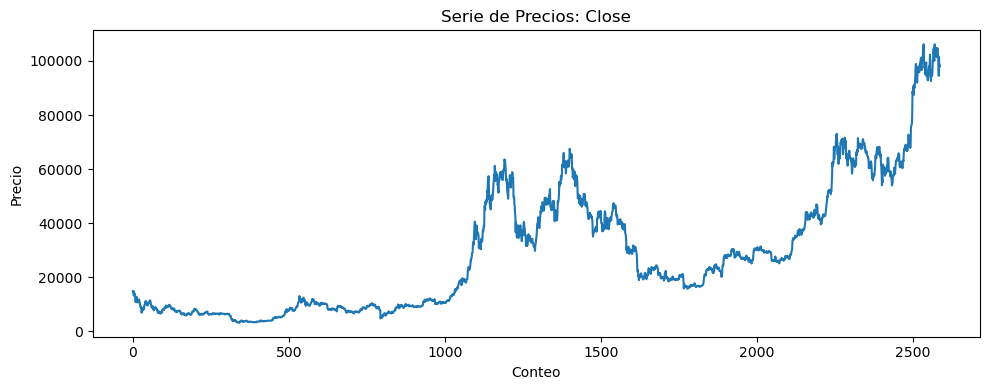

In [5]:
# (a) Serie de precios (Close)
plt.figure(figsize=(10,4))
btc['Close'].plot()
plt.title('Serie de Precios: Close')
plt.xlabel('Conteo'); plt.ylabel('Precio'); plt.tight_layout()
plt.show()

Se puede identificar como a medida que pasa el tiempo la criptomoneda ha ido incrementando su valor de cierre, a excepción de algunos periodos en los que representó pérdidas. En los primeros 1000 se podría concluir que se mantuvo constante en valores cercanos a los 10000, para luego subir a valores de casi 60000. Al final después de haber tenido una pérdida considerable, se puede evidenciar como la criptomoneda se recupera alcanzando así valores cercanos o mayores a los 100000

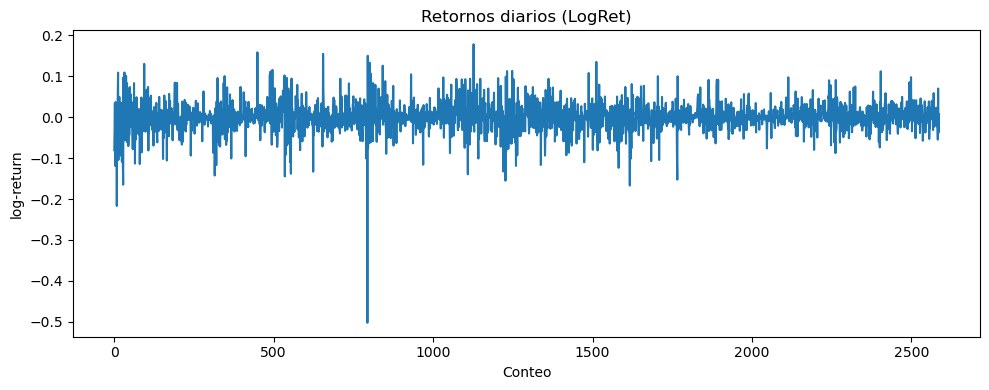

In [6]:
# (b) Serie de retornos (usaremos LogRet por estabilidad)
plt.figure(figsize=(10,4))
btc['LogReturn'].dropna().plot()
plt.title('Retornos diarios (LogRet)')
plt.xlabel('Conteo'); plt.ylabel('log-return'); plt.tight_layout()
plt.show()

Se puede evidenciar que hay un periodo en particular en el que los retornos diarios son completamente desfavorables para el tradeo en la criptomoneda

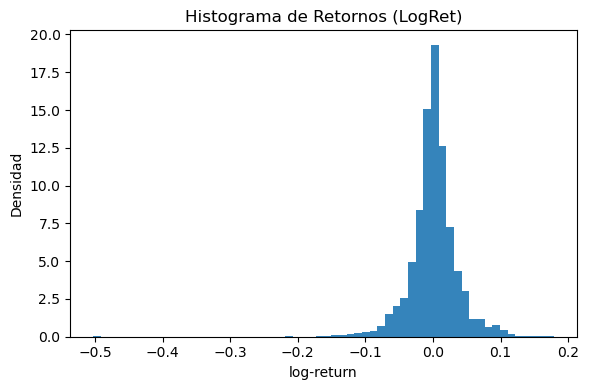

In [7]:
# (c) Histograma de retornos (log)
r = btc['LogReturn'].dropna()
plt.figure(figsize=(6,4))
plt.hist(r, bins=60, alpha=0.9, density=True)
plt.title('Histograma de Retornos (LogRet)')
plt.xlabel('log-return'); plt.ylabel('Densidad'); plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

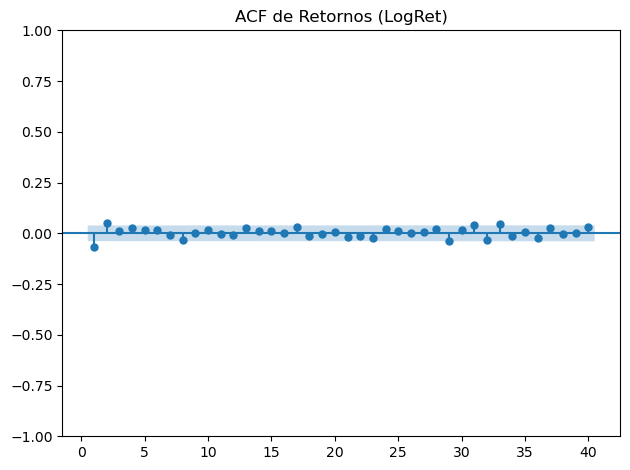

In [8]:
# (d) ACF de retornos (LogRet)
plt.figure(figsize=(8,4))
plot_acf(r, lags=40, zero=False)
plt.title('ACF de Retornos (LogRet)')
plt.tight_layout()
plt.show()

<Figure size 800x400 with 0 Axes>

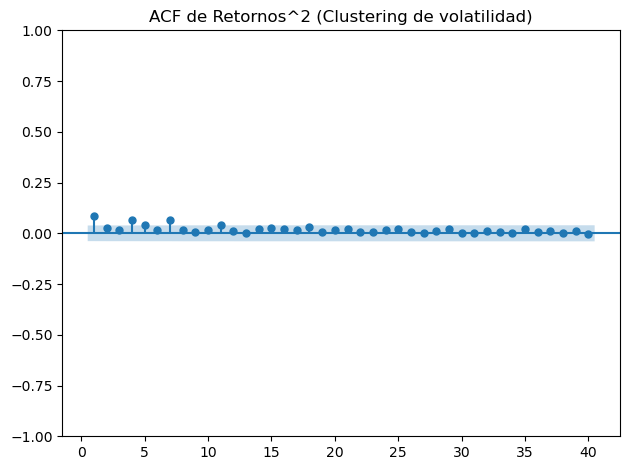

In [9]:
# (e) ACF de retornos al cuadrado (heterocedasticidad)
plt.figure(figsize=(8,4))
plot_acf((r**2), lags=40, zero=False)
plt.title('ACF de Retornos^2 (Clustering de volatilidad)')
plt.tight_layout()
plt.show()

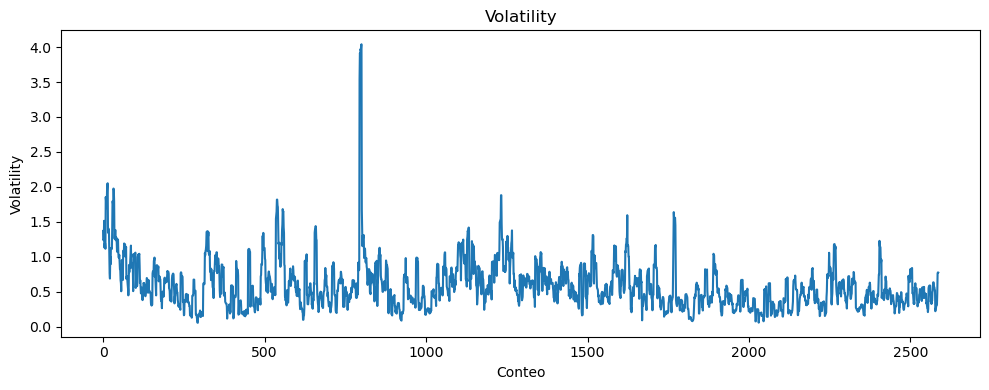

In [10]:
plt.figure(figsize=(10,4))
btc['Volatility'].plot()
plt.title('Volatility')
plt.xlabel('Conteo'); plt.ylabel('Volatility'); plt.tight_layout()
plt.show()